# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
!pip install phik -q
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from phik.report import plot_correlation_matrix
from sklearn.metrics import  mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
!pip install --upgrade scikit-learn 1.3.1
!pip install --upgrade pip
!pip install shap -q
import warnings
warnings.filterwarnings("ignore")


    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
  Using cached scikit_learn-1.5.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
ERROR: Could not find a version that satisfies the requirement 1.3.1 (from versions: none)
ERROR: No matching distribution found for 1.3.1
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [2]:
df = pd.read_csv('/datasets/autos.csv')
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


*Приведем названия колонок к нижнему регистру*

In [3]:
df.columns = df.columns.str.lower()
df

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


*Приведем названия колонок к змеиному регистру*

In [4]:
df=df.rename(columns={
    'datecrawled': 'date_crawled',
    'vehicletype': 'vehicle_type',
    'registrationyear': 'registration_year',
    'registrationmonth': 'registration_month',
    'fueltype': 'fuel_type',
    'datecreated': 'date_created',
    'numberofpictures': 'number_of_pictures',
    'postalcode': 'postal_code',
    'lastseen': 'last_seen',    
}
)

In [5]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

*Проверим на пропуски методом isna()*

In [7]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

 *Посмотрим на дубликаты методом duplicated().sum()*

In [8]:
df.duplicated().sum()

4

**Вывод-Загрузили данные, импортировали библиотеки, привели к нужному виду названия колонок. Изучили данные методом info(), посчитали пропуски и дубликаты. Данные требуют предобработки. В столбцах date_crawled и date_created нужно привести тип данных к типу datetime, во многих столбцах есть пропуски и дубликаты. Необходимо их обработать**


<div class="alert alert-block alert-success">
<b>Успех:</b> Первичный осмотр проведен
</div>

In [9]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])
df['date_crawled'].dtype

dtype('<M8[ns]')

In [10]:
df['date_created'] = pd.to_datetime(df['date_created'])   
df['date_created'].dtype

dtype('<M8[ns]')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

*Посчитаем количество пропусков в каждом столбце и поймем можно ли их удалить* 

In [12]:
df['vehicle_type'].isna().sum()

37490

*пропусков тут больше 10 процентов. Удалять нельзя, но можно заменить например на 'unknown' или похожее значение. Посмотрим на уникальные значения методом value_counts().*

In [13]:
df['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

*Заменм пропуски в данном столбце на значение - other*

In [14]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')

In [15]:
df['gearbox'].isna().sum()

19833

In [16]:
df['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [17]:
df['gearbox'] = df['gearbox'].fillna('unknown')

In [18]:
df['model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

In [19]:
df['model'] = df['model'].fillna('other')

In [20]:
df['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [21]:
df['fuel_type'] =df['fuel_type'].fillna('unknown')

In [22]:
df['repaired'].value_counts()

no     247161
yes     36054
Name: repaired, dtype: int64

In [23]:
df['repaired']=df['repaired'].fillna('unknown')

In [24]:
df = df.drop_duplicates()

In [25]:
df.duplicated().sum()

0

In [26]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [27]:
num_columns = df[['price', 'registration_year', 'power', 'kilometer', 'registration_month']]
cat_columns = df[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']]

In [28]:
df['kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

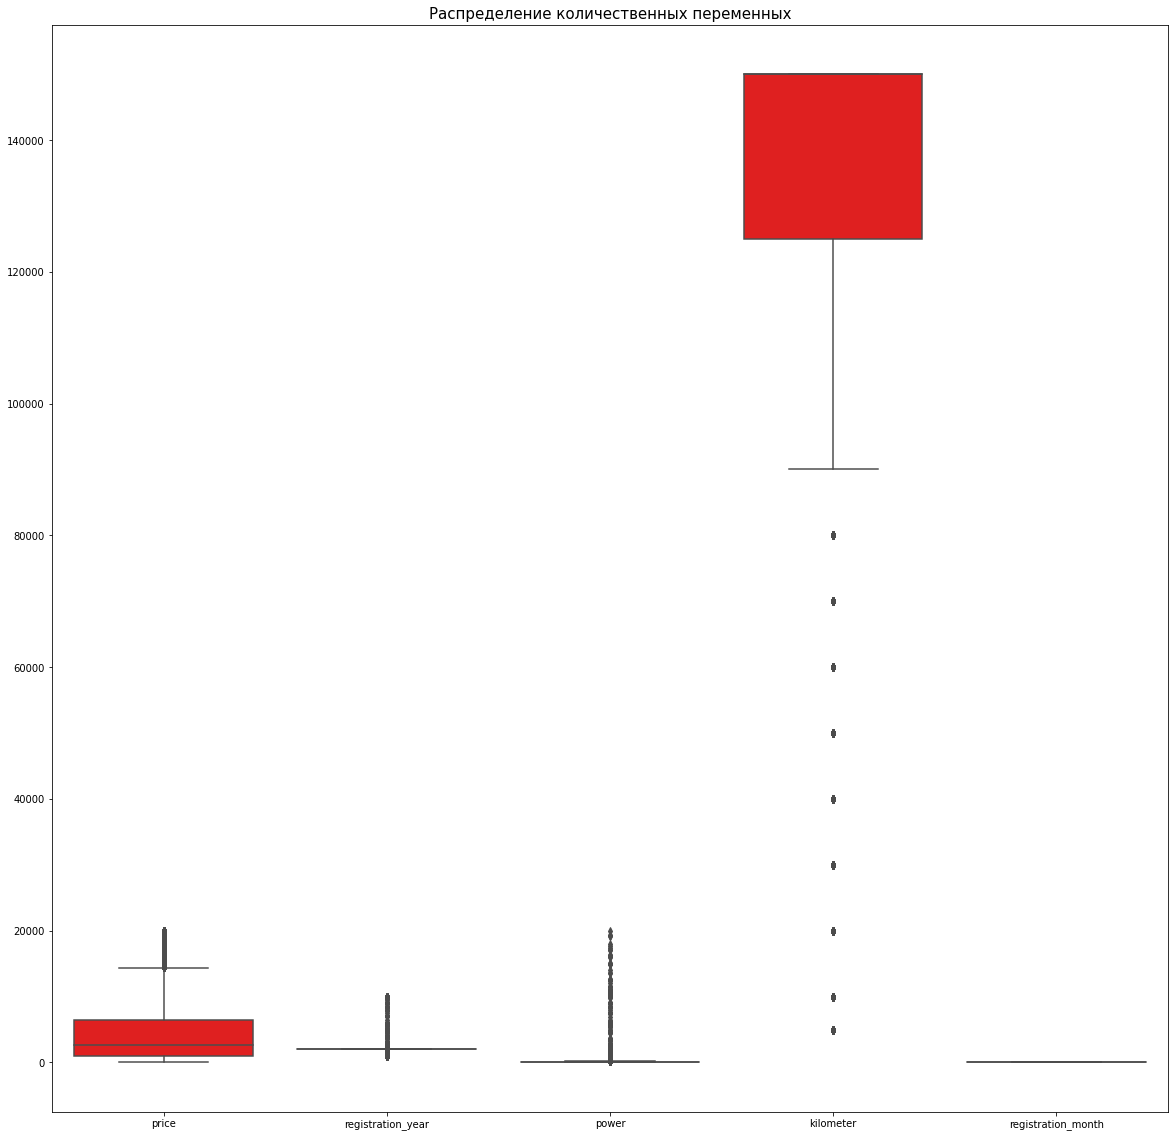

In [29]:
plt.figure(figsize=(20, 20))
plt.xlim(-0.1, 2)
sns.boxplot(data=num_columns, color='red')
plt.title('Распределение количественных переменных', fontsize=15)
plt.show()

In [30]:
df['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

*В стобце год регистрации имеются недопустимые значения, такие как 1111 год, 3800 год и тд. Удалим такие значения методом query. возьмем период с 1930 года и по настоящий период*

In [31]:
df.query('1930 <= registration_year <= 2024')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,other,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,other,2005,unknown,0,other,20000,1,unknown,sonstige_autos,unknown,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


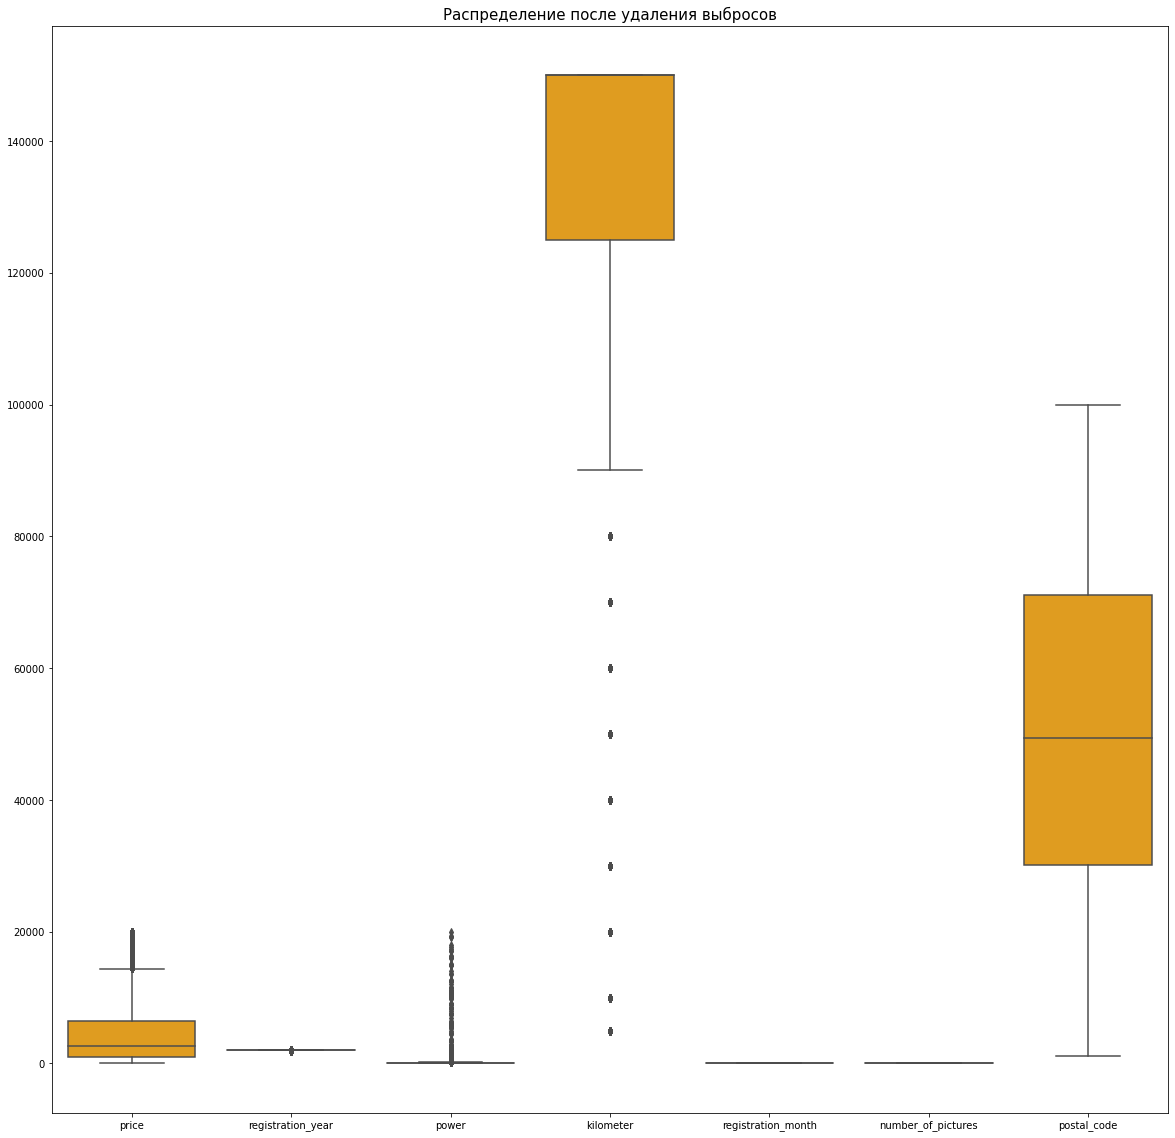

In [32]:
new_num_cols = df.query('1930 <= registration_year <= 2024')
plt.figure(figsize=(20, 20))
plt.xlim(-0.1, 2)
sns.boxplot(data=new_num_cols, color='orange')
plt.title('Распределение после удаления выбросов', fontsize=15)
plt.show();

In [33]:
df.query('1930 <= registration_year <= 2024')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,other,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,other,2005,unknown,0,other,20000,1,unknown,sonstige_autos,unknown,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


*Посмотрим на уникальные значениия методо values_counts() и на мин и макс значения метоом describe()*

In [34]:
df['power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: power, Length: 712, dtype: int64

In [35]:
df['power'].describe()

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

*Сразу видно, что таких максимальных значений в 20000 л.с. и минииальных в 0 л.с. быть не может. Это выбросы. Согласно интернету , если брать ретро автомобили с минимальной мощностью, то там значение от 0,75 л.с. Это автомобиль Benz Patent Motorwagen. Максимальная же мощность равна 1600 л.с. Это Hennessey Venom F5. Будем исходить из этого промежутка*

In [36]:
df['price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

In [37]:
df['price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

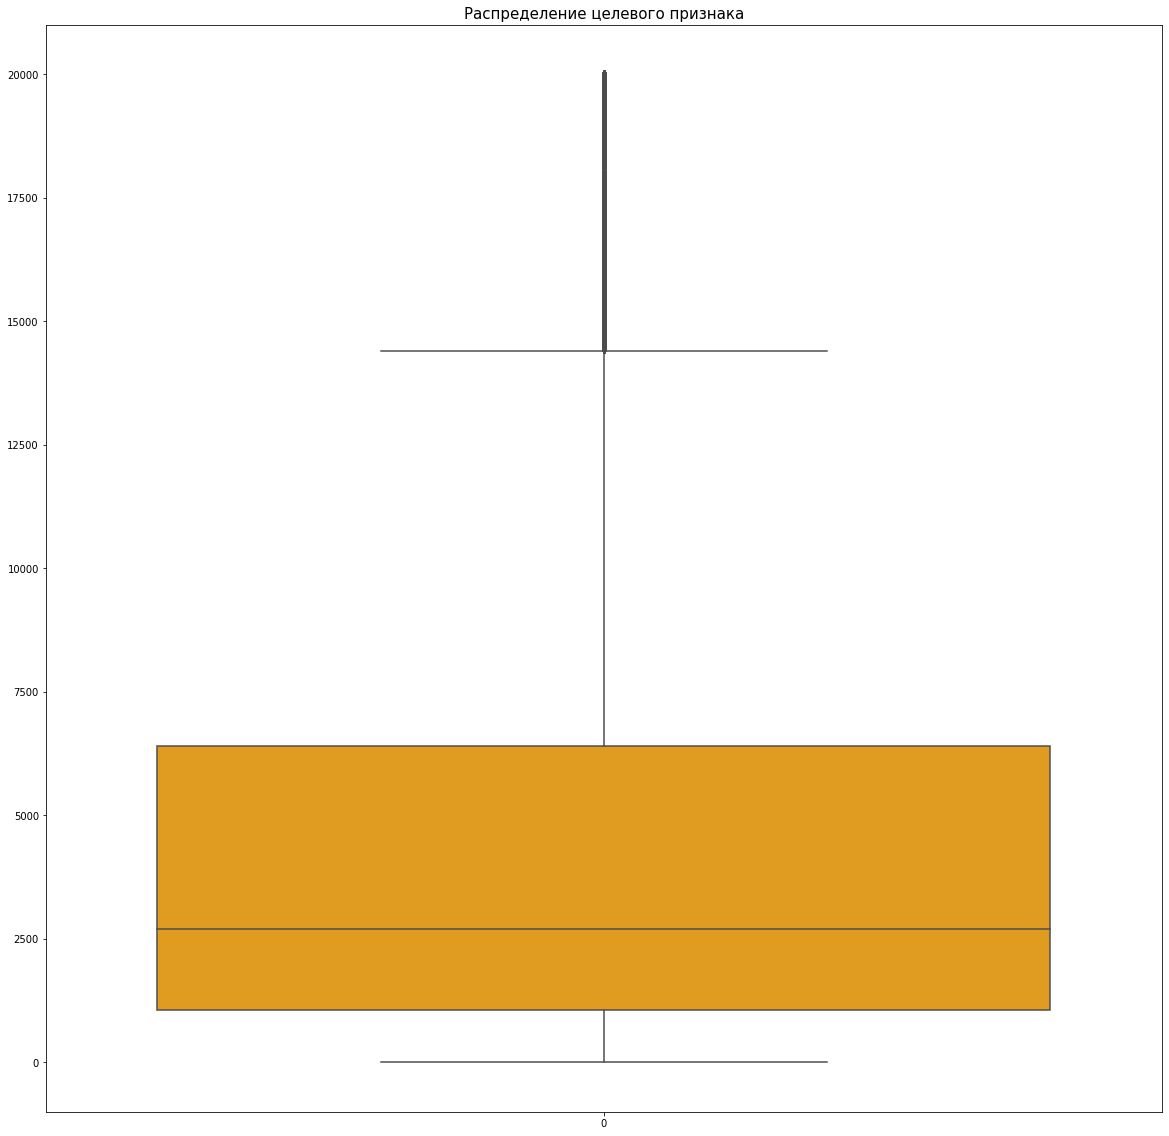

In [38]:
plt.figure(figsize=(20, 20))
plt.xlim(-0.1, 2)
sns.boxplot(data=df['price'], color='orange')
plt.title('Распределение целевого признака', fontsize=15)
plt.show();

*Возьмем значения целевого признака больше 500 евро и менее 14000, удалив выбросы и нулевые значения*

*Итоговый датасет получится такой*

In [39]:
df.query('1930 <= registration_year <= 2024 and 0.75 <= power <= 1600 and  price > 500')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,2016-03-09 13:37:43,5250,other,2016,auto,150,159,150000,12,unknown,alfa_romeo,no,2016-03-09,0,51371,2016-03-13 01:44:13
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19,0,96465,2016-03-19 20:44:43
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


## Обучение моделей

*Удалим ненужные столбцы перед обучением модели*

In [40]:
features = df.drop(['price', 'date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
target = df['price']





<div class="alert alert-block alert-success">
<b>Успех:</b> Удалить неинформативные признаки - верное решение
</div>

In [41]:
print(features.shape, target.shape)

(354365, 9) (354365,)


In [42]:
features_train, features_test_valid, target_train, target_test_valid = train_test_split(
features, target, test_size = 0.4, random_state = 12345
)
features_test, features_valid, target_test, target_valid = train_test_split(
features_test_valid, target_test_valid, test_size = 0.5, random_state = 12345
)

In [43]:
ohe_columns = ['vehicle_type', 'fuel_type', 'gearbox', 'repaired']
ord_columns = ['model', 'brand']
num_columns = ['registration_year', 'power', 'kilometer']

In [44]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(handle_unknown = 'ignore', sparse=False)
        )
    ]
)

ohe_pipe

In [45]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['golf', 'other', 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz',
       'beetle', 'c1', 'rio', 'touareg', 'logan', 'spider', 'cuore',
       's_max', 'a2', 'galaxy', 'c3', 'viano', 's_klasse', '1_reihe',
       'avensis', 'roomster', 'sl', 'kaefer', 'santa', 'cooper', 'leon',
       '4_reihe', 'a5', '500', 'laguna', 'ptcruiser', 'clk', 'primera',
       'x_reihe', 'exeo', '159', 'transit', 'juke', 'qashqai', 'carisma',
       'accord', 'corolla', 'lanos', 'phaeton', 'verso', 'swift', 'rav',
       'picanto', 'boxster', 'kalos', 'superb', 'stilo', 'alhambra',
       'mx_reihe', 'roadster', 'ypsilon', 'cayenne', 'galant', 'justy',
       '90', 'sirion', 'crossfire', 'agila', 'duster', 'cr_reihe', 'v50',
       'c_reihe', 'v_klasse', 'm_klasse', 'yaris', 'c5', 'aygo', 'cc',
       'carnival', 'fusion', '911', 'bora', 'forfour', 'm_reihe', 'cl',
       'tigra', '300c', 'spark', 'v70', 'kuga', 'x_type', 'ducato',
       's_type', 'x_trail', 'toledo', 'altea', 'voyager', 'calibra',
       'bravo', 'antara', 'tucson', 'citigo', 'jimny', 'wrangler',
       'lybra', 'q7', 'lancer', 'captiva', 'c2', 'discovery',
       'freelander', 'sandero', 'note', '900', 'cherokee', 'clubman',
       'samara', 'defender', '601', 'cx_reihe', 'legacy', 'pajero',
       'auris', 'niva', 's60', 'nubira', 'vivaro', 'g_klasse', 'lodgy',
       '850', 'range_rover', 'q3', 'serie_2', 'glk', 'charade', 'croma',
       'outlander', 'doblo', 'musa', 'move', '9000', 'v60', '145', 'aveo',
       '200', 'b_max', 'range_rover_sport', 'terios', 'rangerover', 'q5',
       'range_rover_evoque', 'materia', 'delta', 'gl', 'kalina', 'amarok',
       'elefantino', 'i3', 'kappa', 'serie_3', 'serie_1'],
        ['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'],                    
                        ],
                handle_unknown = 'use_encoded_value',
                unknown_value = np.nan              
            )),
            ('simpleImputer_after_ord', SimpleImputer(missing_values=-1, strategy='most_frequent'))
            
    ]
)

In [46]:
ord_pipe

Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(categories=[['golf', 'other', 'grand', 'fabia',
                                             '3er', '2_reihe', 'c_max',
                                             '3_reihe', 'passat', 'navara',
                                             'ka', 'polo', 'twingo', 'a_klasse',
                                             'scirocco', '5er', 'meriva',
                                             'arosa', 'c4', 'civic',
                                             'transporter', 'punto', 'e_klasse',
                                             'clio', 'kadett', 'kangoo',
                                             'corsa', 'o...
                                             'mazda', 'nissan', 'renault',
                                             'mercedes_benz', 'opel', 'seat',
                                             'citroen

In [47]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
) 

In [48]:
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['vehicle_type', 'fuel_type', 'gearbox',
                                  'repaired']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('or...
                                                                              'hyundai',
                                                

In [49]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('scaler', StandardScaler()),
        ('linear_regression', LinearRegression())]
)
pipe_final.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'fuel_type',
                                                   'gearbox', 'repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                  

In [50]:
pipe_final.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'fuel_type',
                                                   'gearbox', 'repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                  

In [51]:
predictions = pipe_final.predict(features_valid)

In [52]:
MSE = mean_squared_error(target_valid, predictions)
RMSE = MSE**0.5
print(f'Средняя квадратичная ошибка равнв: {RMSE}')

Средняя квадратичная ошибка равнв: 3449.6128284222054


*Замерим время обучения каждой модели*

In [53]:
%%timeit
pipe_final.fit(features_valid, target_valid)

513 ms ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


*Это сильно больше целевого значения в 2500 по условию задачи*

*Обучим следующую модель DecisionTreeRegressor градиентным бустингом*

*Возьмем количество деревьев n = 10, learning_rate = 0.1 и обучим модель в цикле*

*Найдем константное предсказание df['price'].mean()*

In [54]:
features_train

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
259924,sedan,2012,manual,170,a3,50000,gasoline,audi,yes
144286,convertible,1988,manual,72,golf,150000,petrol,volkswagen,no
309926,convertible,2009,auto,45,fortwo,125000,gasoline,smart,no
193125,coupe,1962,manual,75,other,150000,petrol,volvo,yes
139397,convertible,1999,manual,220,boxster,125000,petrol,porsche,no
...,...,...,...,...,...,...,...,...,...
47873,sedan,1997,manual,90,6_reihe,150000,petrol,mazda,no
86398,sedan,1996,manual,101,other,125000,petrol,volkswagen,no
347560,small,1994,manual,0,cuore,150000,petrol,daihatsu,unknown
77285,sedan,2007,manual,120,cooper,100000,petrol,mini,no


In [55]:
df['price_pred'] = df['price'].mean()

In [56]:
df[['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'price', 'price_pred']]

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,price,price_pred
0,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown,480,4416.67983
1,coupe,2011,manual,190,other,125000,gasoline,audi,yes,18300,4416.67983
2,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,9800,4416.67983
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1500,4416.67983
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3600,4416.67983
...,...,...,...,...,...,...,...,...,...,...,...
354364,other,2005,manual,0,colt,150000,petrol,mitsubishi,yes,0,4416.67983
354365,other,2005,unknown,0,other,20000,unknown,sonstige_autos,unknown,2200,4416.67983
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,1199,4416.67983
354367,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,9200,4416.67983


In [57]:
df['residuals'] = df['price'] - df['price_pred']
df[['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'price', 'price_pred', 'residuals']]

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,price,price_pred,residuals
0,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown,480,4416.67983,-3936.67983
1,coupe,2011,manual,190,other,125000,gasoline,audi,yes,18300,4416.67983,13883.32017
2,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,9800,4416.67983,5383.32017
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1500,4416.67983,-2916.67983
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3600,4416.67983,-816.67983
...,...,...,...,...,...,...,...,...,...,...,...,...
354364,other,2005,manual,0,colt,150000,petrol,mitsubishi,yes,0,4416.67983,-4416.67983
354365,other,2005,unknown,0,other,20000,unknown,sonstige_autos,unknown,2200,4416.67983,-2216.67983
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,1199,4416.67983,-3217.67983
354367,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,9200,4416.67983,4783.32017


In [58]:
pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('scaler', StandardScaler()),
        ('regressor', DecisionTreeRegressor(max_depth=3)),        
    ]
)
pipe_final_2.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'fuel_type',
                                                   'gearbox', 'repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                  

In [59]:
n = 10
nu = 0.1
trees = []
predictions = np.zeros_like(target_train, dtype=float)  # Initialize predictions for training
predictions_valid = np.zeros_like(target_valid, dtype=float)  # Initialize predictions for validation


for i in range(n):
    residuals = target_train - predictions
    pipe_final_2.fit(features_train, residuals)
    predictions += nu * pipe_final_2.predict(features_train)
    predictions_valid += nu * pipe_final_2.predict(features_valid)
    trees.append(pipe_final_2)
    RMSE=mean_squared_error(target_valid, predictions_valid )**0.5
    print(f'Средняя квадратичная ошибка равна: {RMSE}')

Средняя квадратичная ошибка равна: 5829.4393555170855
Средняя квадратичная ошибка равна: 5404.188553782078
Средняя квадратичная ошибка равна: 5031.748241632852
Средняя квадратичная ошибка равна: 4705.117704383655
Средняя квадратичная ошибка равна: 4409.335647568767
Средняя квадратичная ошибка равна: 4155.069749890684
Средняя квадратичная ошибка равна: 3926.4740512711983
Средняя квадратичная ошибка равна: 3729.7473969551074
Средняя квадратичная ошибка равна: 3555.163006670726
Средняя квадратичная ошибка равна: 3393.855075752955


*Видно, что при 10 деревьях ошибка слишком большая. Возьмем больше деревьев и посмотрим на ошибку*

In [60]:
n = 20
nu = 0.1
trees = []
predictions = np.zeros_like(target_train, dtype=float)  # Initialize predictions for training
predictions_valid = np.zeros_like(target_valid, dtype=float)  # Initialize predictions for validation


for i in range(n):
    residuals = target_train - predictions
    pipe_final_2.fit(features_train, residuals)
    predictions += nu * pipe_final_2.predict(features_train)
    predictions_valid += nu * pipe_final_2.predict(features_valid)
    trees.append(pipe_final_2)
    RMSE=mean_squared_error(target_valid, predictions_valid )**0.5
    print(f'Средняя квадратичная ошибка равна: {RMSE}')

Средняя квадратичная ошибка равна: 5829.4393555170855
Средняя квадратичная ошибка равна: 5404.188553782031
Средняя квадратичная ошибка равна: 5031.748241632806
Средняя квадратичная ошибка равна: 4705.117704383633
Средняя квадратичная ошибка равна: 4409.335647568726
Средняя квадратичная ошибка равна: 4155.069749890646
Средняя квадратичная ошибка равна: 3926.4740512711614
Средняя квадратичная ошибка равна: 3729.7473969551006
Средняя квадратичная ошибка равна: 3555.163006670734
Средняя квадратичная ошибка равна: 3393.8550757529647
Средняя квадратичная ошибка равна: 3263.599661926908
Средняя квадратичная ошибка равна: 3141.4256093506438
Средняя квадратичная ошибка равна: 3035.866074585105
Средняя квадратичная ошибка равна: 2949.762166329569
Средняя квадратичная ошибка равна: 2869.066229713319
Средняя квадратичная ошибка равна: 2797.990231957912
Средняя квадратичная ошибка равна: 2738.4755875333058
Средняя квадратичная ошибка равна: 2683.979522958391
Средняя квадратичная ошибка равна: 2638.

*Все еще большая ошибка*


*Увеличим learning_rate до 0.5*

In [61]:
n = 20
nu = 0.5
trees = []
predictions = np.zeros_like(target_train, dtype=float)  # Initialize predictions for training
predictions_valid = np.zeros_like(target_valid, dtype=float)  # Initialize predictions for validation


for i in range(n):
    residuals = target_train - predictions
    pipe_final_2.fit(features_train, residuals)
    predictions += nu * pipe_final_2.predict(features_train)
    predictions_valid += nu * pipe_final_2.predict(features_valid)
    trees.append(pipe_final_2)
   

*Не помогло. Попробуем взять количество деревьев 9*

In [62]:
n = 9
nu = 0.1
trees = []
predictions = np.zeros_like(target_train, dtype=float)  # Initialize predictions for training
predictions_valid = np.zeros_like(target_valid, dtype=float)  # Initialize predictions for validation


for i in range(n):
    residuals = target_train - predictions
    pipe_final_2.fit(features_train, residuals)
    predictions += nu * pipe_final_2.predict(features_train)
    predictions_valid += nu * pipe_final_2.predict(features_valid)
    trees.append(pipe_final_2)
   

In [63]:
pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('scaler', StandardScaler()),
        ('regressor', DecisionTreeRegressor(random_state = 12345, max_depth=2)),
        
    ]
)
pipe_final_2.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'fuel_type',
                                                   'gearbox', 'repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                  

In [64]:
n = 10
nu = 0.1
trees = []
predictions = np.zeros_like(target_train, dtype=float)  # Initialize predictions for training
predictions_valid = np.zeros_like(target_valid, dtype=float)  # Initialize predictions for validation


for i in range(n):
    residuals = target_train - predictions
    pipe_final_2.fit(features_train, residuals)
    predictions += nu * pipe_final_2.predict(features_train)
    predictions_valid += nu * pipe_final_2.predict(features_valid)
    trees.append(pipe_final_2)
 

*Построим матрицу корреляции признаков, чтобы понять есть ли лишние признаки*

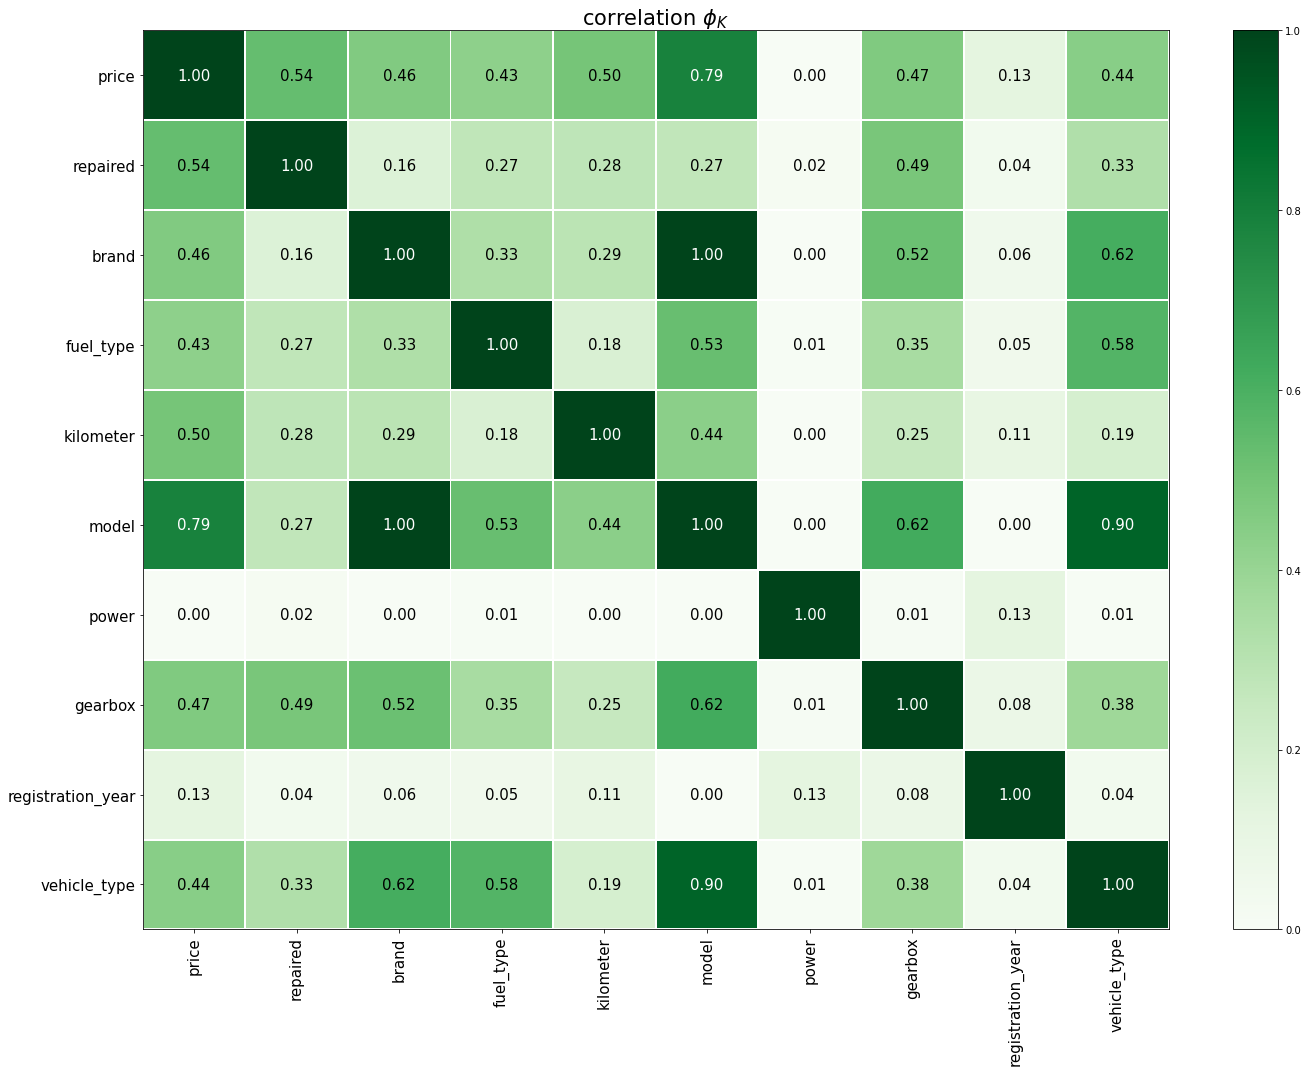

In [65]:
interval_cols = ['registration_year', 'power', 'kilometer']

phik_overview = features_train.join(target_train).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

*На лицо мультиколлинеарность между признаками model и brand*

*Попробуем удалить лишний признак 'model' и переобучить модель*

In [66]:
features = features.drop(['model'], axis=1)
target = df['price']
features

,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
0,other,1993,manual,0,150000,petrol,volkswagen,unknown
1,coupe,2011,manual,190,125000,gasoline,audi,yes
2,suv,2004,auto,163,125000,gasoline,jeep,unknown
3,small,2001,manual,75,150000,petrol,volkswagen,no
4,small,2008,manual,69,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...
354364,other,2005,manual,0,150000,petrol,mitsubishi,yes
354365,other,2005,unknown,0,20000,unknown,sonstige_autos,unknown
354366,convertible,2000,auto,101,125000,petrol,smart,no
354367,bus,1996,manual,102,150000,gasoline,volkswagen,no


<div class="alert alert-block alert-success">
<b>Успех:</b>  Допустимое решение
</div>


In [67]:
features_train, features_test_valid, target_train, target_test_valid = train_test_split(
features, target, test_size = 0.4, random_state = 12345
)
features_test, features_valid, target_test, target_valid = train_test_split(
features_test_valid, target_test_valid, test_size = 0.5, random_state = 12345
)

In [68]:
ohe_columns = ['vehicle_type', 'fuel_type', 'gearbox', 'repaired']
ord_columns = ['brand']
num_columns = ['power', 'kilometer', 'registration_year']

In [69]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(handle_unknown = 'ignore', sparse=False)
        )
    ]
)

ohe_pipe

In [70]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                            ['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada']                  
                        ],
                handle_unknown = 'use_encoded_value',
                unknown_value = np.nan              
            )),
            ('simpleImputer_after_ord', SimpleImputer(missing_values=-1, strategy='most_frequent'))
            
    ]
)

In [71]:
ord_pipe

Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(categories=[['volkswagen', 'audi', 'jeep',
                                             'skoda', 'bmw', 'peugeot', 'ford',
                                             'mazda', 'nissan', 'renault',
                                             'mercedes_benz', 'opel', 'seat',
                                             'citroen', 'honda', 'fiat', 'mini',
                                             'smart', 'hyundai',
                                             'sonstige_autos', 'alfa_romeo',
                                             'subaru', 'volvo', 'mitsubishi',
                                             'kia', 'suzuki', 'lancia',
                                             'toyota', 'chevrolet', 'dacia', ...]],
                                handle_unknown='use_encoded_value',
                                unknown

In [72]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
) 

In [73]:
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['vehicle_type', 'fuel_type', 'gearbox',
                                  'repaired']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('or...
                                                                              'hyundai',
                                                

In [74]:

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('scaler', StandardScaler()),
        ('linear_regression', LinearRegression())]
)
pipe_final.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'fuel_type',
                                                   'gearbox', 'repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                  

In [75]:
predictions = pipe_final.predict(features_valid)

*Ошибка после удаления признака почти не изменилась. Была 5374, стала 5369, что говорит о том, что ошибка не связана с мультиколлениарностью признаков model и brand*

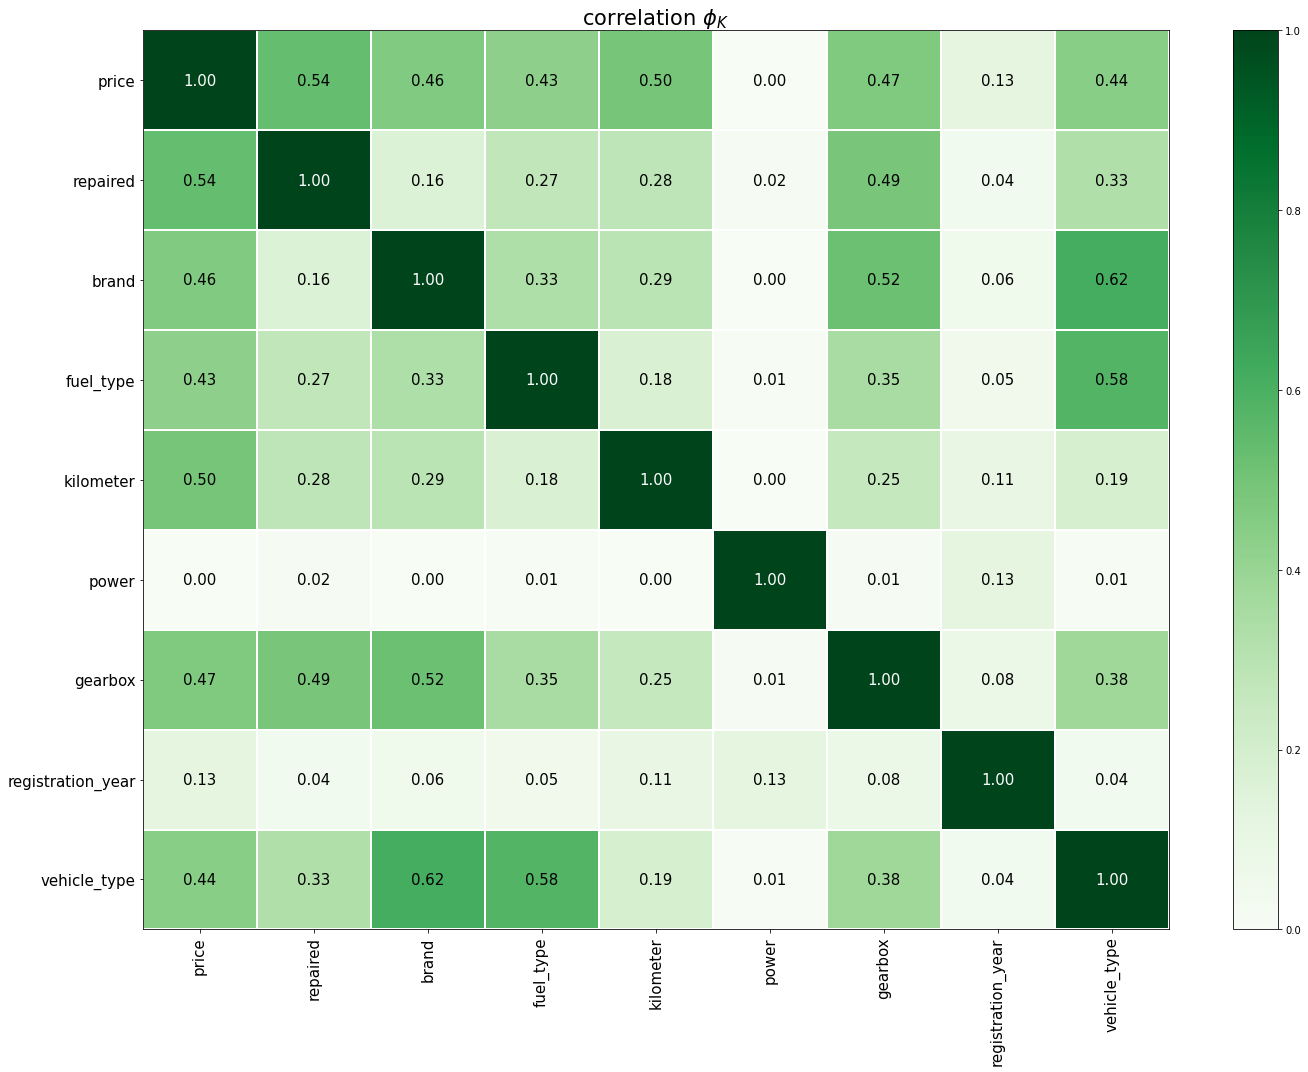

In [76]:
interval_cols = ['registration_year', 'power', 'kilometer']

phik_overview = features_train.join(target_train).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

*Больше убирать лишние признаки смысла нет поскольку их нет. Посмотрим на другие модели* 

In [77]:
pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('scaler', StandardScaler()),
        ('regressor', DecisionTreeRegressor(random_state = 12345, max_depth=1, max_features=8)),
        
    ]
)
pipe_final_2.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'fuel_type',
                                                   'gearbox', 'repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                  

In [78]:
n = 10
nu = 0.1
trees = []
predictions = np.zeros_like(target_train, dtype=float)  # Initialize predictions for training
predictions_valid = np.zeros_like(target_valid, dtype=float)  # Initialize predictions for validation


for i in range(n):
    residuals = target_train - predictions
    pipe_final_2.fit(features_train, residuals)
    predictions += nu * pipe_final_2.predict(features_train)
    predictions_valid += nu * pipe_final_2.predict(features_valid)
    trees.append(pipe_final_2)

In [79]:
pipe_final_3 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('scaler', StandardScaler()),
        ('regressor', LGBMRegressor(random_state=12345, verbose=-1)),
        
    ]
)
pipe_final_3.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'fuel_type',
                                                   'gearbox', 'repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                  

*Время работы модели равно 19.5 секунд и 151 миллисекунды*

*После удаления признака ошибка е еще большая, попробуем поменять еще параметры*

*Поиграли с параметрами, ошибка не меняется и остается в пределах 5000 -5700*

*Постром градиентный бустинг с помощью модели LightGBM по условиям задачи*

In [80]:
lgbm_params = {
    'regressor__n_estimators': [100, 500],
    'regressor__max_depth': [3, 6]
}

In [81]:
neg_root_mean_squared_error = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [82]:
random_search = RandomizedSearchCV(estimator=pipe_final_3, param_distributions=lgbm_params, scoring='neg_root_mean_squared_error', cv=5, n_iter=10, random_state=42)
random_search.fit(features_train, target_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['vehicle_type',
                     

In [83]:
best_params = random_search.best_params_
best_score = random_search.best_score_

In [84]:
print(f'Лучшие параметры: {best_params}')
print(f'Лучшая метрика: {best_score}')

Лучшие параметры: {'regressor__n_estimators': 500, 'regressor__max_depth': 6}
Лучшая метрика: -1802.3786606634967


## Анализ моделей

In [85]:
%%timeit
pipe_final.fit(features_train, target_train)

1.2 s ± 45.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%%timeit
pipe_final_2.fit(features_train, target_train)

746 ms ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
%%timeit
pipe_final_3.fit(features_train, target_train)

6.6 s ± 1.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
%%timeit
pipe_final.predict(features_valid)

300 ms ± 822 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
%%timeit
pipe_final_2.predict(features_valid)

112 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
%%timeit
pipe_final_3.predict(features_valid)

701 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


*По замеру времени обучения лучшее время показала модель DecisionTreeRegressor - 658 ms. По времени предсказания также выигрывает эта модель - 102ms. Посчитаем предсказания и метрику RMSE на валидационной выборке всех трех моделей*

In [91]:
predictions_valid_model_1 = pipe_final.predict(features_valid)

In [92]:
RMSE_1 = mean_squared_error(target_valid, predictions_valid_model_1)**0.5
print(f'Средняя квадратичная ошибка на валидационной выборке первой модели равна: {RMSE_1}')

Средняя квадратичная ошибка на валидационной выборке первой модели равна: 3462.7062499751587


In [93]:
predictions_valid_model_2 = pipe_final_2.predict(features_valid)

In [94]:
RMSE_2 = mean_squared_error(target_valid, predictions_valid_model_2)**0.5
print(f'Средняя квадратичная ошибка на валидационной выборке второй модели равна: {RMSE_2}')

Средняя квадратичная ошибка на валидационной выборке второй модели равна: 3793.1851706692983


In [95]:
predictions_valid_model_3 = pipe_final_3.predict(features_valid)

In [96]:
RMSE_3 = mean_squared_error(target_valid, predictions_valid_model_3)**0.5
print(f'Средняя квадратичная ошибка на валидационной выборке третей модели равна: {RMSE_3}')

Средняя квадратичная ошибка на валидационной выборке третей модели равна: 1866.4613920709266


*По времени обучения и времени предсказания выигрывает вторая модель DecisionTreeRegressor, но учитывая главное условие задания получить метрику качества RMSE < 2500, выигрывает третья модель LGBMRegressor со знаением метрики в 1866.46. В остальрных моделях значение метрики < 2500 получить не удалось. Поэтому мы рекомендуем заказчику модель LGBMRegressor c найденными параметрами, но для контрольного замера потестим модель на тестовой выборке для окончательного решения*

In [97]:
predictions_test = pipe_final_3.predict(features_test)

In [98]:
mse_test = mean_squared_error(target_test, predictions_test)

In [99]:
RMSE_test = mse_test**0.5

In [100]:
print(f'Средняя квадратичная ошибка на теcтовой выборке LGBM модели равна: {RMSE_test}')

Средняя квадратичная ошибка на теcтовой выборке LGBM модели равна: 1882.9037106316662


*Метрика RMSE на тестовой выборке почти такая же как и на валидационной с небольшой разницей в 16 пунктов(1866 и 1882 соответственно). Наш вывод о том, что лучшая модель LGBMRegressor, подтвердился, и мы рекомендуем заказчику именно эту модель с наилучшим значением качества в 1882, что подпадает под условие RMSE<2500.*

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей